Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
18000 [D loss: 0.311127, acc.: 87.50%] [G loss: 3.600044]
4/4 [==============================] - 0s 3ms/step
19000 [D loss: 0.217710, acc.: 89.84%] [G loss: 3.524011]
4/4 [==============================] - 0s 4ms/step
20000 [D loss: 0.481300, acc.: 77.34%] [G loss: 2.557163]
1/1 [==============================] - 0s 20ms/step


<ipython-input-1-16bccfffbb60>:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 5))


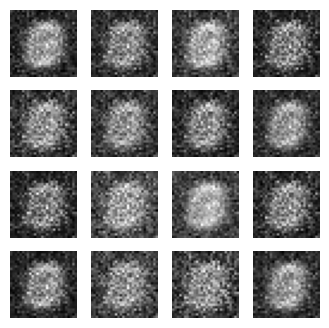

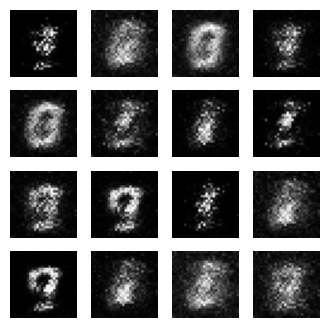

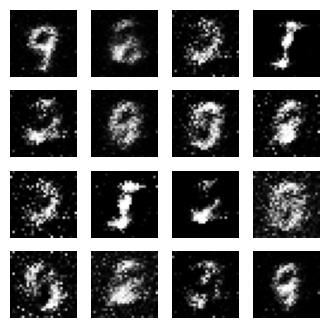

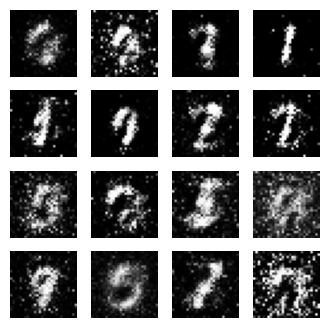

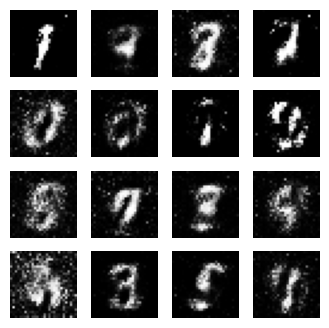

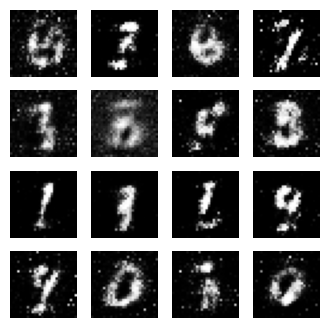

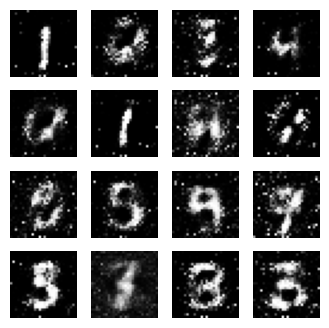

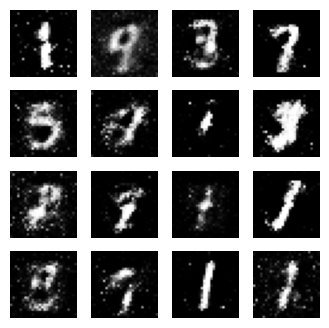

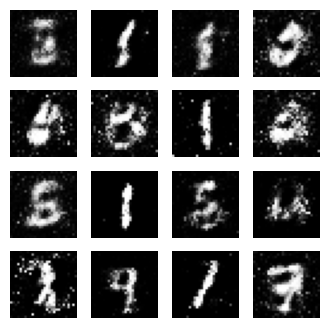

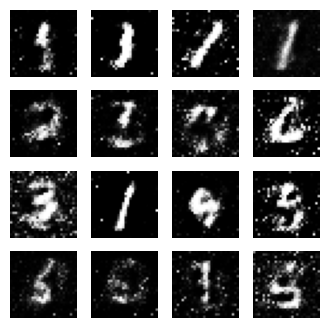

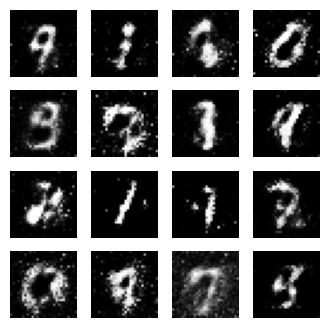

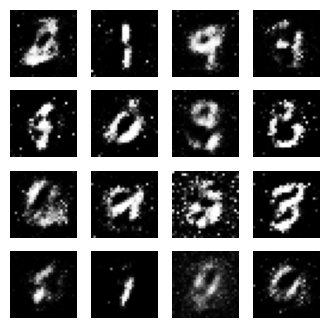

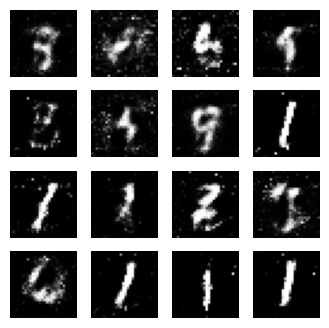

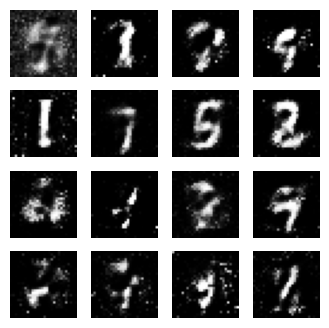

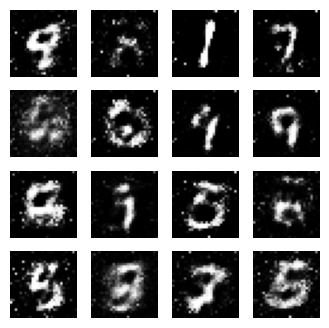

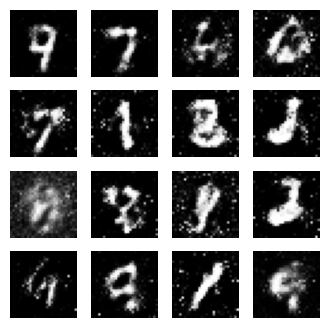

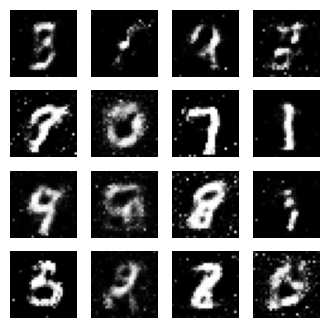

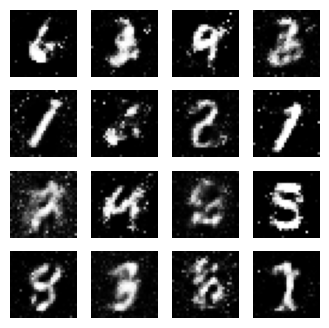

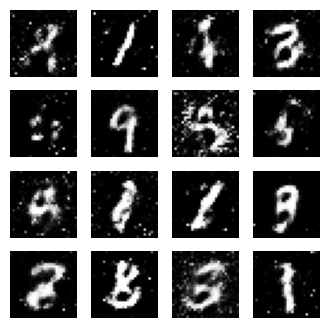

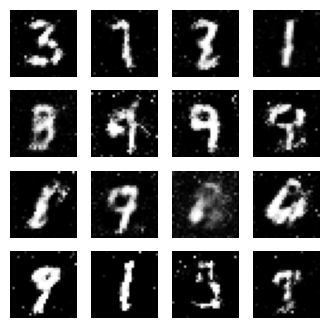

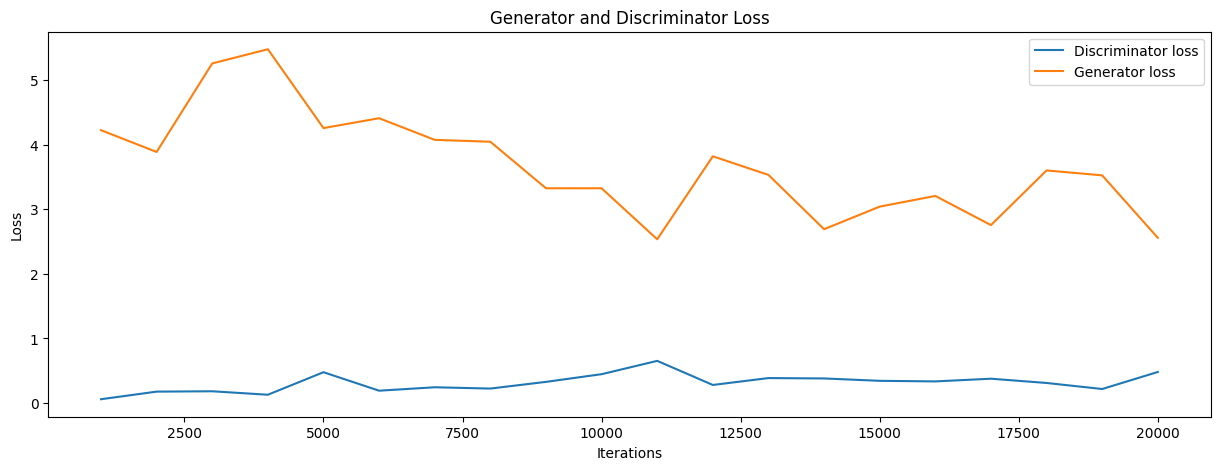

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

def build_generator(img_shape, z_dim):
    model = Sequential()

    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))

    return model

def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))

    return model

def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

losses = []
accuracies = []
iteration_checkpoints = []

def plot_losses(losses, iteration_checkpoints):
    d_losses = [loss[0] for loss in losses]
    g_losses = [loss[1] for loss in losses]

    plt.figure(figsize=(15, 5))

    plt.plot(iteration_checkpoints, d_losses, label="Discriminator loss")
    plt.plot(iteration_checkpoints, g_losses, label="Generator loss")

    plt.title("Generator and Discriminator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()

    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)

    plot_losses(losses, iteration_checkpoints)

def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)
